In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np
import talib
from ta.trend import EMAIndicator
import matplotlib.pyplot as plt
import ta
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv, find_dotenv

In [2]:
load_dotenv()

True

In [3]:
ticker = ["SPY"]
# Set timeframe to "1Day" for Alpaca API
timeframe = "1day"
# Format current date as ISO format
start_date = pd.Timestamp("2019-01-06", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2023-01-28", tz="America/New_York").isoformat()
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)


stock_data = api.get_bars(
    ticker,
    timeframe,
    start=start_date,
    end=end_date
).df

# Reorganize the DataFrame
# Separate ticker data
# Drop unwanted coloumns - Keep  Close
#stock_data.drop(columns= ['trade_count','vwap','symbol'], inplace= True)
    # Combine individual stocks into a single data frame

  # Rename the coloumns to the ticker symbols in the list
#stock_data.columns = ticker
stock_data.index.name = 'Date'
stock_data.index_column = 'Date'
# Drop the N/As


# Drop the time component of the date
#df_ticker.index = df_ticker.index.date


# Display the data
display(stock_data)

,open,high,low,close,volume,trade_count,vwap,symbol
Date,,,,,,,,
2019-01-07 05:00:00+00:00,252.700,255.9500,251.69,254.29,103705813,449998,254.069565,SPY
2019-01-08 05:00:00+00:00,256.820,257.3100,254.00,256.62,103267687,461977,255.845300,SPY
2019-01-09 05:00:00+00:00,257.560,258.9100,256.19,257.92,95741225,438058,257.817252,SPY
2019-01-10 05:00:00+00:00,256.260,259.1600,255.50,258.98,98012473,417182,257.827540,SPY
2019-01-11 05:00:00+00:00,257.680,259.0098,257.03,258.81,74684741,298075,258.331868,SPY
...,...,...,...,...,...,...,...,...
2023-01-23 05:00:00+00:00,396.720,402.6450,395.72,400.63,84187957,568843,399.770552,SPY
2023-01-24 05:00:00+00:00,398.880,401.1500,397.64,400.20,59549719,434698,399.936054,SPY
2023-01-25 05:00:00+00:00,395.950,400.7000,393.56,400.35,84826825,583807,397.858257,SPY


In [4]:
# Calculate the Exponential Moving Average (EMA)
def EMA(stock_data, window):
    EMA = stock_data['close'].ewm(span=window).mean()
    return EMA

In [5]:
window1=8
window2=20
# Calculate the difference between the two EMAs
def EMA_difference(stock_data, window1, window2):
    EMA1 = EMA(stock_data, window1)
    EMA2 = EMA(stock_data, window2)
    difference = EMA1 - EMA2
    return difference


In [6]:
# Create the feature set
stock_data['EMA_difference'] = EMA_difference(stock_data, 8, 20)
stock_data['EMA_signal'] = np.where(stock_data['EMA_difference'] > 0, 1, 0)
stock_data = stock_data.dropna()

In [7]:

# Split the data into training and testing sets
X = stock_data[['open', 'high', 'low', 'volume']]
y = stock_data['EMA_signal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [9]:

# Make predictions on the testing set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)


In [10]:

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Squared Error:', mse)
print('R2 Score:', r2)

Mean Squared Error: 0.21951219512195122
R2 Score: -0.07093104248897109


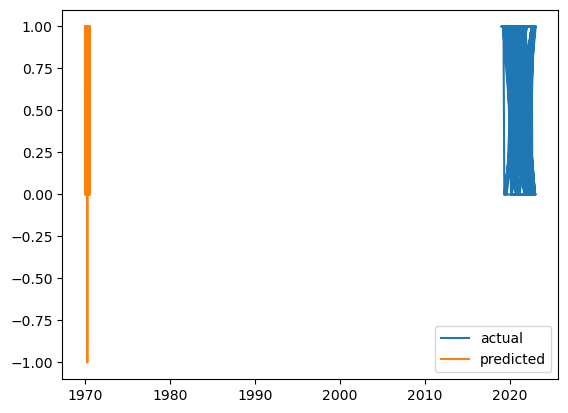

In [11]:
# Plot the actual and predicted values
plt.plot(y_test, label='actual')
plt.plot(y_pred, label='predicted')
plt.legend()
plt.show()